In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
from src.infra import config

path = '../../config/vec.yaml'
opt = config.load_config(path)
opt.path = path

## Dataset & dataloader

In [5]:
from pathlib import Path

data_root = Path('/Users/knpob/Dev/data/3dMD/jump')

In [6]:
from src.dataset.shape_cor_fast import ShapeDatasetFast

dataset = ShapeDatasetFast(
    data_root=data_root,
    mesh_type='ply',
    return_faces=True,
    return_L=True,
    return_mass=True,
    num_evecs=200,
    return_evecs=True,
    return_grad=True,
    return_corr=False,
    return_dist=False,
)
len(dataset)

64

In [7]:
from src.dataset.shape_cor_fast import PairShapeDataset

pair_dataset = PairShapeDataset(dataset)
len(pair_dataset)

4096

In [8]:
from src.dataloader.shape_cor_batch import BatchShapePairDataLoader

dataloader = BatchShapePairDataLoader(
    pair_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
)
len(dataloader)

4096

In [9]:
for idx, data in enumerate(dataloader):
    if idx > 20:
        break

data['first']['name'], data['second']['name'], 

(['S6_nude_jump120_0309_0372.000001'], ['S6_nude_jump120_0309_0372.000022'])

## Inference

In [10]:
from src.network.urssm import URSSM_vectorized

network = URSSM_vectorized(opt=opt).to(device)
network.load_state_dict(torch.load('output/3dmd-trained/model-512.pth', map_location=device))
network

URSSM_vectorized(
  (point_descriptor): WKS_vectorized()
  (feature_extractor): DiffusionNet_vectorized(
    (first_lin): Linear(in_features=128, out_features=128, bias=True)
    (last_lin): Linear(in_features=128, out_features=256, bias=True)
    (block_0): DiffusionNetBlock(
      (diffusion): LearnedTimeDiffusion()
      (gradient_features): SpatialGradientFeatures(
        (A_re): Linear(in_features=128, out_features=128, bias=False)
        (A_im): Linear(in_features=128, out_features=128, bias=False)
      )
      (mlp): MiniMLP(
        (miniMLP_mlp_layer_000): Linear(in_features=384, out_features=128, bias=True)
        (miniMLP_mlp_act_000): ReLU()
        (miniMLP_mlp_layer_dropout_001): Dropout(p=0.5, inplace=False)
        (miniMLP_mlp_layer_001): Linear(in_features=128, out_features=128, bias=True)
        (miniMLP_mlp_act_001): ReLU()
        (miniMLP_mlp_layer_dropout_002): Dropout(p=0.5, inplace=False)
        (miniMLP_mlp_layer_002): Linear(in_features=128, out_feature

In [11]:
import pyvista as pv

name_x, name_y = data['first']['name'][0], data['second']['name'][0]
mesh_x = pv.read(data_root / 'ply' / f"{name_x}.ply")
mesh_y = pv.read(data_root / 'ply' / f"{name_y}.ply")

name_x, name_y

('S6_nude_jump120_0309_0372.000001', 'S6_nude_jump120_0309_0372.000022')

### LBO

In [12]:
lbo_x, lbo_y = data['first']['evecs'], data['second']['evecs']
scale_x, scale_y = data['first']['mass'][0].max(), data['second']['mass'][0].max()
lbo_x.shape, lbo_y.shape, scale_x, scale_y

(torch.Size([1, 5000, 200]),
 torch.Size([1, 5000, 200]),
 tensor(913.7964),
 tensor(2238.5378))

In [13]:
from tqdm import tqdm

for dim in tqdm(range(0, 200, 10)):
    mesh_x['val'] = (lbo_x[0, :, dim] * scale_x).cpu().numpy()
    mesh_y['val'] = (lbo_y[0, :, dim] * scale_y).cpu().numpy()
    pl = pv.Plotter()
    pl.add_mesh(
        mesh=mesh_x,
        scalars=f'val',
        cmap='coolwarm',
        clim=[-1, 1],
        show_scalar_bar=False,
    )
    pl.add_mesh(
        mesh=mesh_y.translate([1000, 0, 0]),
        scalars=f'val',
        cmap='coolwarm',
        clim=[-1, 1],
        show_scalar_bar=False,
    )
    pl.camera_position = 'xy'

    export_dir = Path('output/3dmd-trained/lbo')
    export_dir.mkdir(parents=True, exist_ok=True)
    pl.screenshot(export_dir / f'{name_x} - {name_y} - base{dim}.png', window_size=[1024, 1024], return_img=False)

100%|██████████| 20/20 [00:04<00:00,  4.54it/s]


### Point descriptors

In [14]:
des_x = network.point_descriptor(
    evals=data['first']['evals'],
    evecs=data['first']['evecs'],
    mass=data['first']['mass'],
)
des_y = network.point_descriptor(
    evals=data['second']['evals'],
    evecs=data['second']['evecs'],
    mass=data['second']['mass'],
)
des_x.shape, des_y.shape

(torch.Size([1, 5000, 128]), torch.Size([1, 5000, 128]))

In [15]:
for dim in tqdm(range(0, 128, 10)):
    mesh_x['val'] = des_x[0, :, dim].cpu().numpy()
    mesh_y['val'] = des_y[0, :, dim].cpu().numpy()
    pl = pv.Plotter()
    pl.add_mesh(
        mesh=mesh_x,
        scalars=f'val',
        cmap='coolwarm',
        show_scalar_bar=False,
    )
    pl.add_mesh(
        mesh=mesh_y.translate([1000, 0, 0]),
        scalars=f'val',
        cmap='coolwarm',
        show_scalar_bar=False,
    )
    pl.camera_position = 'xy'

    export_dir = Path('output/3dmd-trained/point_desc')
    export_dir.mkdir(parents=True, exist_ok=True)
    pl.screenshot(export_dir / f'{name_x} - {name_y} - dim{dim}.png', window_size=[1024, 1024], return_img=False)

100%|██████████| 13/13 [00:01<00:00,  8.00it/s]


### DiffusionNet

In [16]:
feat_x = network.feature_extractor(
    x_in=des_x,
    verts_mask=data['first']['verts_mask'],
    mass=data['first']['mass'],
    evals=data['first']['evals'],
    evecs=data['first']['evecs'],
    gradX=torch.sparse_coo_tensor(
        data['first']['gradX_indices'],
        data['first']['gradX_values'],
        data['first']['gradX_size'],
    ),
    gradY=torch.sparse_coo_tensor(
        data['first']['gradY_indices'],
        data['first']['gradY_values'],
        data['first']['gradY_size'],
    ),
)
feat_y = network.feature_extractor(
    x_in=des_y,
    verts_mask=data['second']['verts_mask'],
    mass=data['second']['mass'],
    evals=data['second']['evals'],
    evecs=data['second']['evecs'],
    gradX=torch.sparse_coo_tensor(
        data['second']['gradX_indices'],
        data['second']['gradX_values'],
        data['second']['gradX_size'],
    ),
    gradY=torch.sparse_coo_tensor(
        data['second']['gradY_indices'],
        data['second']['gradY_values'],
        data['second']['gradY_size'],
    ),
)
feat_x.shape, feat_y.shape

(torch.Size([1, 5000, 256]), torch.Size([1, 5000, 256]))

In [17]:
for dim in tqdm(range(0, 128, 10)):
    mesh_x['val'] = feat_x[0, :, dim].detach().cpu().numpy()
    mesh_y['val'] = feat_y[0, :, dim].detach().cpu().numpy()
    pl = pv.Plotter()
    pl.add_mesh(
        mesh=mesh_x,
        scalars=f'val',
        cmap='coolwarm',
        show_scalar_bar=False,
    )
    pl.add_mesh(
        mesh=mesh_y.translate([1000, 0, 0]),
        scalars=f'val',
        cmap='coolwarm',
        show_scalar_bar=False,
    )
    pl.camera_position = 'xy'

    export_dir = Path('output/3dmd-trained/diff_feat')
    export_dir.mkdir(parents=True, exist_ok=True)
    pl.screenshot(export_dir / f'{name_x} - {name_y} - dim{dim}.png', window_size=[1024, 1024], return_img=False)

100%|██████████| 13/13 [00:02<00:00,  4.83it/s]


### Regularized FMNet

#### From point descriptors

In [18]:
Cxy, Cyx = network.fm_solver(
    feat_x=des_x,
    feat_y=des_y,
    evals_x=data['first']['evals'],
    evals_y=data['second']['evals'],
    evecs_trans_x=data['first']['evecs_trans'],
    evecs_trans_y=data['second']['evecs_trans'],
    bidirectional=True,
)
Cxy.shape, Cyx.shape

(torch.Size([1, 200, 200]), torch.Size([1, 200, 200]))

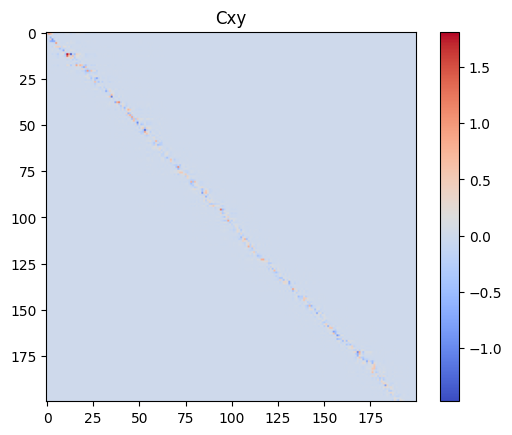

In [19]:
import matplotlib.pyplot as plt

output_path = Path('output/3dmd-trained/Cyx-point-desc')
output_path.mkdir(parents=True, exist_ok=True)

plt.imshow(
    Cxy[0, :, :].detach().cpu().numpy(), 
    cmap='coolwarm',
)
plt.colorbar()
plt.title('Cxy')
plt.savefig(output_path / 'Cxy.png')

In [20]:
import shutil
from src.utils.fmap import fmap2pointmap_vectorized
from src.utils.fmap import pointmap2Pyx_vectorized
from src.utils.tensor import to_numpy
from src.utils.texture import write_obj_pair

p2p = fmap2pointmap_vectorized(
    Cxy,
    data['first']['evecs'], data['second']['evecs'],
    data['first']['verts_mask'], data['second']['verts_mask']
)

Pyx = pointmap2Pyx_vectorized(
    p2p=p2p,
    evecs_x = data['first']['evecs'],
    evecs_y = data['second']['evecs'],
    evecs_trans_x = data['first']['evecs_trans'],
    evecs_trans_y = data['second']['evecs_trans'],
)

shutil.copy('output/3dmd-trained/texture.png', output_path / 'texture.png')

write_obj_pair(
    file_name1=str(output_path / f'{name_x}.obj'),
    file_name2=str(output_path / f'{name_x}-{name_y}.obj'),
    verts1=to_numpy(data['first']['verts'][0]),
    faces1=to_numpy(data['first']['faces'][0]),
    verts2=to_numpy(data['second']['verts'][0]),
    faces2=to_numpy(data['second']['faces'][0]),
    Pyx=to_numpy(Pyx[0]),
    texture_file=str(output_path / 'texture.png'),
)

In [21]:
pl = pv.Plotter()
pl.add_mesh(
    mesh=pv.read(output_path / f'{name_x}.obj'),
    texture=pv.read_texture(output_path / 'texture.png'),
)
pl.add_mesh(
    mesh=pv.read(output_path / f'{name_x}-{name_y}.obj').translate([1000, 0, 0]),
    texture=pv.read_texture(output_path / 'texture.png'),
)
pl.camera_position = 'xy'
pl.screenshot(output_path / f'{name_x} - {name_y}.png', window_size=[1024, 1024], return_img=False)

#### From DiffusionNet features

In [22]:
Cxy, Cyx = network.fm_solver(
    feat_x=feat_x,
    feat_y=feat_y,
    evals_x=data['first']['evals'],
    evals_y=data['second']['evals'],
    evecs_trans_x=data['first']['evecs_trans'],
    evecs_trans_y=data['second']['evecs_trans'],
    bidirectional=True,
)
Cxy.shape, Cyx.shape

(torch.Size([1, 200, 200]), torch.Size([1, 200, 200]))

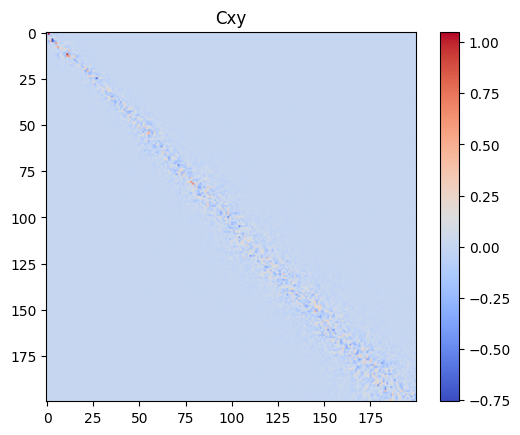

In [23]:
import matplotlib.pyplot as plt

output_path = Path('output/3dmd-trained/Cyx-diff-feat')
output_path.mkdir(parents=True, exist_ok=True)

plt.imshow(
    Cxy[0, :, :].detach().cpu().numpy(), 
    cmap='coolwarm',
)
plt.colorbar()
plt.title('Cxy')
plt.savefig(output_path / 'Cxy.png')

In [24]:
import shutil
from src.utils.fmap import fmap2pointmap_vectorized
from src.utils.fmap import pointmap2Pyx_vectorized
from src.utils.tensor import to_numpy
from src.utils.texture import write_obj_pair

p2p = fmap2pointmap_vectorized(
    Cxy,
    data['first']['evecs'], data['second']['evecs'],
    data['first']['verts_mask'], data['second']['verts_mask']
)

Pyx = pointmap2Pyx_vectorized(
    p2p=p2p,
    evecs_x = data['first']['evecs'],
    evecs_y = data['second']['evecs'],
    evecs_trans_x = data['first']['evecs_trans'],
    evecs_trans_y = data['second']['evecs_trans'],
)

shutil.copy('output/3dmd-trained/texture.png', output_path / 'texture.png')

write_obj_pair(
    file_name1=str(output_path / f'{name_x}.obj'),
    file_name2=str(output_path / f'{name_x}-{name_y}.obj'),
    verts1=to_numpy(data['first']['verts'][0]),
    faces1=to_numpy(data['first']['faces'][0]),
    verts2=to_numpy(data['second']['verts'][0]),
    faces2=to_numpy(data['second']['faces'][0]),
    Pyx=to_numpy(Pyx[0]),
    texture_file=str(output_path / 'texture.png'),
)

In [25]:
pl = pv.Plotter()
pl.add_mesh(
    mesh=pv.read(output_path / f'{name_x}.obj'),
    texture=pv.read_texture(output_path / 'texture.png'),
)
pl.add_mesh(
    mesh=pv.read(output_path / f'{name_x}-{name_y}.obj').translate([1000, 0, 0]),
    texture=pv.read_texture(output_path / 'texture.png'),
)
pl.camera_position = 'xy'
pl.screenshot(output_path / f'{name_x} - {name_y}.png', window_size=[1024, 1024], return_img=False)